[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/9_nb_feature_engineering.ipynb) 

# Data Preprocessing

So far, we've gone through some basic feature pre-processing. Now  we'll further elaborate on pre-processing as well asfeature engineering, which is the art of creating meaningful features from your processed data. In general, you will likely have to use a combination of domain and statistical knowledge to get the most out of your variables. This includes techniques such as scaling and [transforming](https://machinelearningmastery.com/power-transforms-with-scikit-learn/) (there are [other techniques](https://machinelearningmastery.com/power-transforms-with-scikit-learn/) when dealing with time series data). It could also be the creation of new variables using some kind of combination of the variables that you have.

In this tutorial, we will discuss basic feature transformations and feature selections. At best your model should  only include *relevant* variables. Any irrelevant variable will severely hamper the generalization properties of your model. 

We will discuss
- Data Preprocessing and Feature engineering
- Feature selection
- Appendix: Pipelines

# Preliminaries

We will begin as usual, by importing necessary libraries, settings and loading the data. 

In [1]:
# Import standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

# Load credit risk data in pre-processed format from GitHub
data_url = './hmeq_prepared.csv' 
df = pd.read_csv(data_url)

# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

X_train.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DELINQcat,DEROGzero
3120,16900.0,53252.0,89720.0,DebtCon,Office,29.0,0.0,0.0,204.58794,0.0,22.0,33.016150,0,True
1521,11200.0,23181.0,80140.0,HomeImp,ProfExe,21.0,0.0,0.0,221.41809,0.0,10.0,25.462640,0,True
3419,18100.0,144692.0,183630.0,DebtCon,Mgr,11.0,0.0,0.0,256.20547,0.0,21.0,27.384117,0,True
735,8200.0,48515.0,59240.0,DebtCon,Other,17.0,0.0,4.0,214.14452,0.0,36.0,27.459145,1,True
4175,21700.0,187311.0,230513.0,DebtCon,ProfExe,2.0,0.0,0.0,270.47903,0.0,27.0,38.999233,0,True


In [2]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4768, 14) (1192, 14) (4768, 1) (1192, 1)


# More on Preprocessing and Feature Engineering 

From Wikipedia on Data Pre-Processing:

"Data preprocessing can refer to manipulation or dropping of data before it is used in order to ensure or enhance performance,[1] and is an important step in the data mining process. The phrase "garbage in, garbage out" is particularly applicable to data mining and machine learning projects. Data-gathering methods are often loosely controlled, resulting in out-of-range values (e.g., Income: −100), impossible data combinations (e.g., Sex: Male, Pregnant: Yes), and missing values, etc.

Analyzing data that has not been carefully screened for such problems can produce misleading results. Thus, the representation and quality of data is first and foremost before running any analysis.[2] Often, data preprocessing is the most important phase of a machine learning project, especially in computational biology.[3] If there is much irrelevant and redundant information present or noisy and unreliable data, then knowledge discovery during the training phase is more difficult. Data preparation and filtering steps can take considerable amount of processing time. Examples of data preprocessing include cleaning, instance selection, normalization, one hot encoding, transformation, feature extraction and selection, etc. **The product of data preprocessing is the final training set.**"

## Data pipeline construction revisited

Here is an example of how your data preparation process could look like. This will of course depend on the data you are working with and the goal of your model. In general, you may **at least** want to follow these steps:

**1) Basic cleaning of null values, duplicates and outliers**

These values will have a big impact on how Python runs and how models are calculated. When it comes to NaN values and outliers, there are several approaches to deal with them. You could remove them, replace them with another value (indicator value, mode, mean, max, min, etc), use a mini-model to impute them among other options. This has been done for the most part in this data set already. See [Tutorial #4](https://github.com/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb) for details.

**2) Encode variables in the most appropriate way**

Check your dataframe using the method `.info()` . Are your continuous variables encoded as integers or floats? If they are type `object` then the column may need to be checked again for null values. It is good practice to change any categorical variables to the `category` data type as it increases processing time. Once you have confirmed that you will finalize the model with a categorical variable, it can be good to use one-hot encoding as described in step 5.

**3) Ensure variables fit statistical assumptions/model requirements**

The next steps are a bit more complex and will depend on which model you need to use. Your goal is to make sure your data will be accurately processed by your model. Note that a lot of statistical assumptions depend on normal distribution and scaling. For example, models like K-Means and other distance-based methods are very sensitive to the magnitude of variable values.  We will first examine ways to do that.

In this step, you may also want to remove features which are highly correlated to one another.

**4) Filter out variables with low predictive power**

You may now want to examine whether the variables contribute to your model. We will discuss filter methods to do just that. Note that some variables may only be effective in combination with others, so be careful with this step. Recall that wrapper methods for feature selection are more powerful but also more costly.  

**5) One-hot encode categorical variables**

Once you have decided to keep a categorical feature, it can be useful to one-hot encode the feature. Again, one-hot encoding means that instead of one categorical column, you have multiple dummies, which represent possible category values. For example, if your categorical variable "transport" had the possible values of "car", "by foot" or "bus", you would split it into columns called "transport_car" and "transport_bus". "by foot" is indicated if neither of those have a value of 1 for that observation. In this tutorial, we will also learn about an alternative way to deal with categorical features using a weight-of-evidence (WoE) transformation.

**6) Double check the model only includes appropriate variables**

Next, you may want to try a wrapper method or step-wise regression as another check to ensure you are only including relevant variables.

In many cases, you may have to repeat some of these steps several times. Remember the idea of **garbage in, garbage out**. If you feed a model nonsense, expect nonsense to come right back out. This is likely what will take the most of your time as a data scientist.

In [3]:
# Let's get a quick overview of the data types of each column and make sure they are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BAD        5960 non-null   bool   
 1   LOAN       5960 non-null   float64
 2   MORTDUE    5960 non-null   float64
 3   VALUE      5960 non-null   float64
 4   REASON     5960 non-null   object 
 5   JOB        5960 non-null   object 
 6   YOJ        5960 non-null   float64
 7   DEROG      5960 non-null   float64
 8   DELINQ     5960 non-null   float64
 9   CLAGE      5960 non-null   float64
 10  NINQ       5960 non-null   float64
 11  CLNO       5960 non-null   float64
 12  DEBTINC    5960 non-null   float64
 13  DELINQcat  5960 non-null   int64  
 14  DEROGzero  5960 non-null   bool   
dtypes: bool(2), float64(10), int64(1), object(2)
memory usage: 617.1+ KB


Luckily, most of our variables are actually encoded the right way! Let's just change the two categorical variables to a categorical type. Note that this is not a data type in `NumPy`, only in `Pandas`. As such, you may run into problems if the data type becomes relevant in a `NumPy` calculation. Just keep that in mind!

In [4]:
# Let's change our two categorical variables to the correct type for our interim analysis
df['REASON'] = df['REASON'].astype('category')
df['JOB'] = df['JOB'].astype('category')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BAD        5960 non-null   bool    
 1   LOAN       5960 non-null   float64 
 2   MORTDUE    5960 non-null   float64 
 3   VALUE      5960 non-null   float64 
 4   REASON     5960 non-null   category
 5   JOB        5960 non-null   category
 6   YOJ        5960 non-null   float64 
 7   DEROG      5960 non-null   float64 
 8   DELINQ     5960 non-null   float64 
 9   CLAGE      5960 non-null   float64 
 10  NINQ       5960 non-null   float64 
 11  CLNO       5960 non-null   float64 
 12  DEBTINC    5960 non-null   float64 
 13  DELINQcat  5960 non-null   int64   
 14  DEROGzero  5960 non-null   bool    
dtypes: bool(2), category(2), float64(10), int64(1)
memory usage: 535.9 KB


## Scaling

Features will likely have arbitrary magnitudes. For example, a customer's spending range from 0 to 50,000 but a dummy variable about them may only take the value 0 or 1. For many algorithms, like the distance function in kMeans, this is problematic. The distance function will try to minimize differences among features using their raw values. This means that kMeans will focus on variables with arbitrarily high values like spending when that may not be as important as a dummy. One way to deal with this is to scale features so that their values are in a controlled range; without altering the distribution of feature values. This way, all features will be considered equally in distance calculations. 

There are two major ways to scale: standardization and min-max scaling (also known as normalization).

### Standardization
After standardization, your feature will now be distributed around a mean  feature value of zero with standard deviation equal to one.

$$ X_{new} = \frac{X-\mu}{\sigma} $$

There is no controlled or a priori set maximum or minimum value here. This means that standardization does not deal with outliers. You may have a clearer picture of how extreme these outliers are after standardization.

### Min-Max Scaling
After min-max scaling, your variables will have a range of 0 and 1. Minimum feature values will become 0 and maximum values will be 1.

$$ X_{new} = \frac{X-X_{min}}{X_{max}-X_{min}} $$

**NOTE** This type of scaling is sometimes called normalization but you should note that it simply compacts the values of the features to be between 0 and 1, it does not change the overall shape of the data.


In [6]:
# Standardization
def standardize(var):
    return (var - np.mean(var)) / np.std(var)


# Min-max scaling
def min_max_scale(var):
    return (var - min(var)) / (max(var) - min(var))

Let's first look at how this variable looks before and after normalization and standardization using a box plot and then a histogram. **Note the scaling of the y-axes in all of all the following plots.**

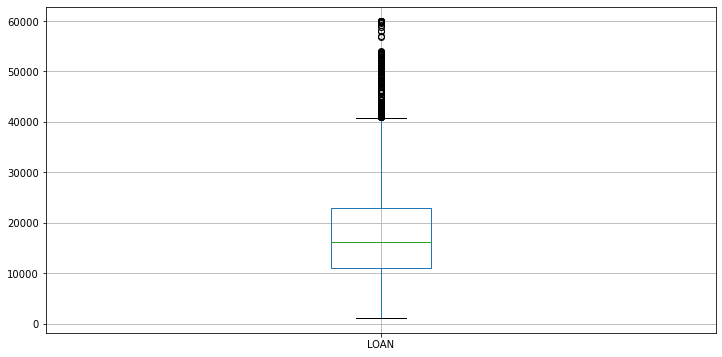

In [7]:
# Raw variable 
X_train[['LOAN']].boxplot();

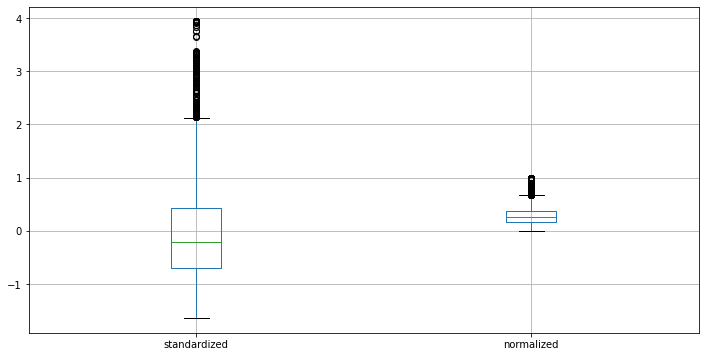

In [8]:
# Comparison of the normalized vs. standardized variable (check axes for size)
loan_standardized = standardize(X_train['LOAN'])
loan_normalized = min_max_scale(X_train['LOAN'])
loans_scaled = pd.DataFrame({"standardized": loan_standardized, "normalized": loan_normalized})
loans_scaled.boxplot();

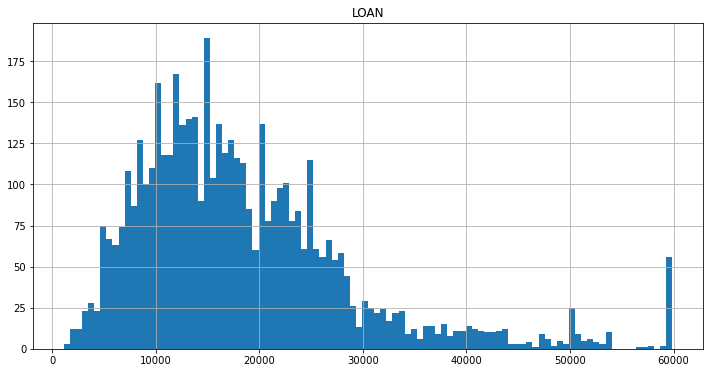

In [9]:
# Histogram of raw variable
X_train[['LOAN']].hist(bins=100);

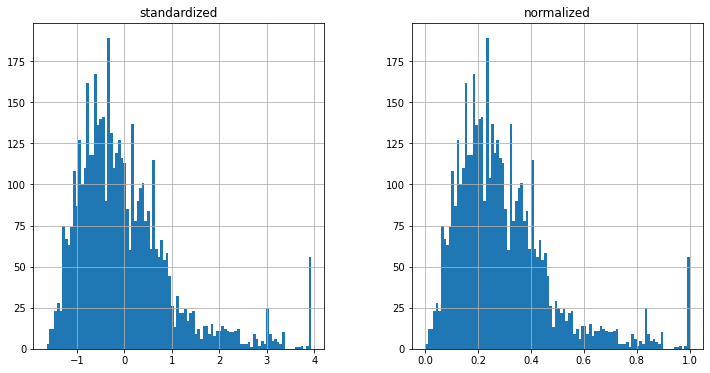

In [10]:
# Comparison of the normalized vs. standardized variable (check axes for size)
loans_scaled.hist(bins=100);

Now we can see the big difference between the two types of scaling. With min-max scaling, we have the variable ranging between 0 and 1. With standard scaling, we have the variable showing us its position relative to standard deviations. Note that in both of these examples, the variable was squeezed into a smaller range but did not change shape overall. There are ways to change its shape, which we will explore next. 

First, let's just quickly look at the standard way to perform scaling when using `sklearn`. We can just use the `MinMaxScaler()` and `StandardScaler` to do what our custom functions did. In practice, we would rely on these routines and avoid coding our own customer functions.

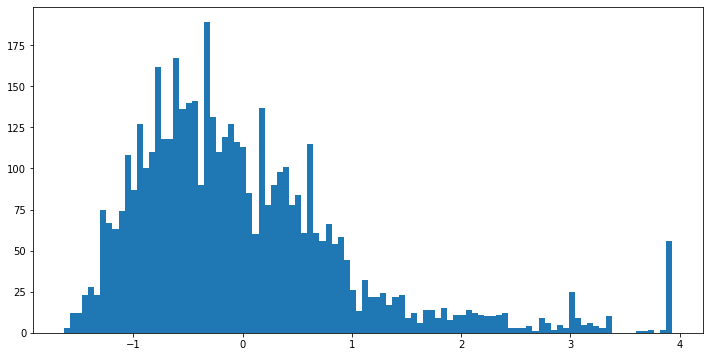

In [11]:
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
standardscaled = standardscaler.fit_transform(X_train[['LOAN']])
_ = plt.hist(standardscaled, bins=100)
plt.show()

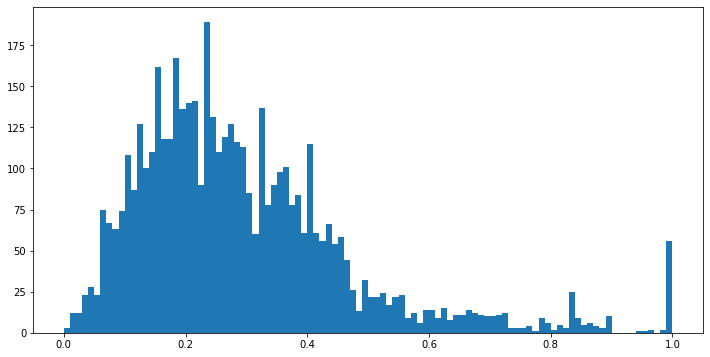

In [12]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()
minmaxscaled = minmaxscaler.fit_transform(X_train[['LOAN']])

_ = plt.hist(minmaxscaled, bins=100)
plt.show()

It is good practice to scale variables before putting them into an algorithm. Note that some algorithms (eg. tree algorithms) don't necessarily require this. Since we will be using a logistic regression initially, we will scale these variables using standard scaling later.

## Checking features for normality

Normality is a critical condition for many statistical tests and the creation of confidence intervals. If this is the goal of your work, you will likely need to find some way to normalize your variables. Further, some methods for descriptive, explanatory or predictive modeling may benefit from normality. Imagine, for example, a dependent variable that displays a complex, non-normal distribution. If the distribution of the dependent is non-normal, it is likely that residuals will also be non-normal, which vialoates an assumption of the linear model. Long story short, many importand data science methods may benefit from feature transformations that change the distribution of a feature such that it becomes more normal. Here we will introduce 3 useful transformations to achieve this: log, Box-Cox and Yeo-Johnson transformations.

There are several ways to check which variables could benefit from such a transformation. One method would be to create a histogram of each variable and check its shape. Remember that you are looking for a perfect bell shape with even tails on either side. As you can imagine, this does not happen very often with many variables.

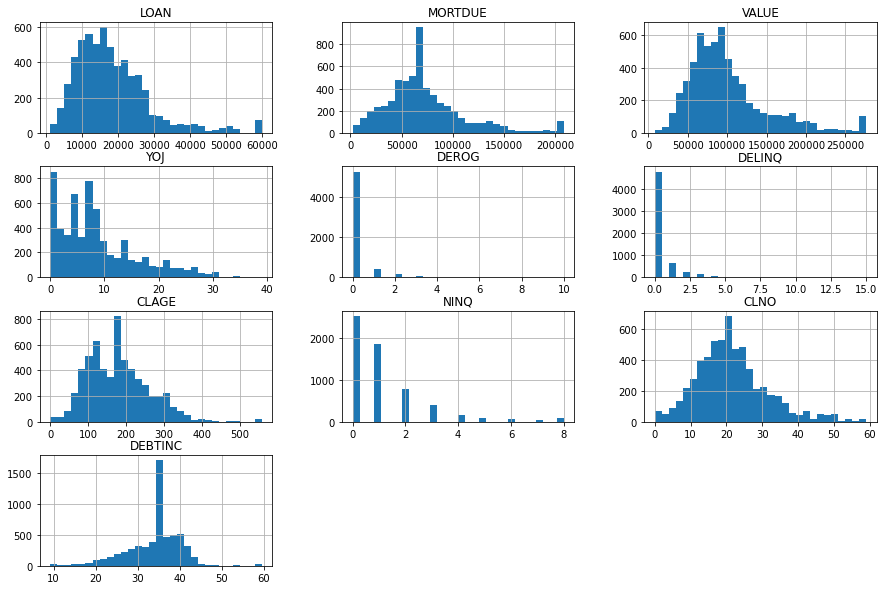

In [13]:
df.select_dtypes(include='float64').hist(bins=30, figsize=(15, 10));

In [14]:
# Choose a feature of interest and we'll take a deep dive into it
# DEROG, DELINQ and NINQ are bad candidates as they resemble categorical variables
feature = df['LOAN'] 

If you would like a more scienfitic test for normality, you can use `normaltest` from `scipy`. This function's documentation is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html). It outputs 2 numbers, the first is the sum of squares of the z-scores returned by a skewtest and kurtosistest. The second is a 2-sided chi2 probability hypothesis test. Thus, if the p-value is below 0.05, it is likely you do not have normally distributed data.

In [15]:
from scipy import stats
stats.normaltest(feature)

NormaltestResult(statistic=1603.6531776769357, pvalue=0.0)

We can see problems a bit more clearly with a quantile-quantile (QQ) plot. Ideally, the blue line should match the red line (quantiles of a feature versus the quantiles/ppf of a distribution). If not, it is less likely that it comes from a normal distribution.

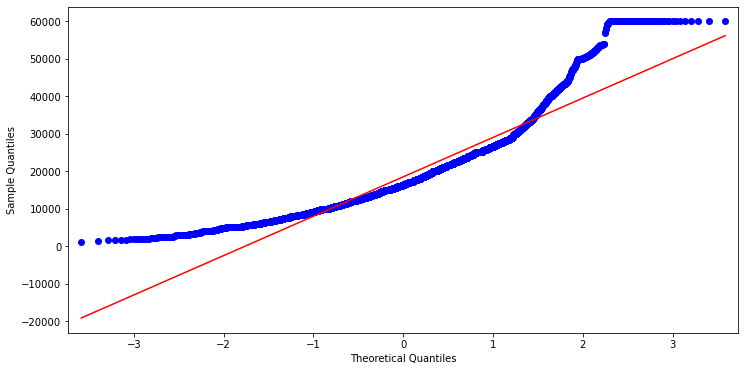

In [16]:
from statsmodels.graphics.gofplots import qqplot
qqplot(feature, line='s')
plt.show()

Just to reiterate that it is a bit misleading to say min-max scaling is "normalization", let's min-max scale our feature and perform the test. As we can see, `normaltest` outputs the same test statistic and pvalue.

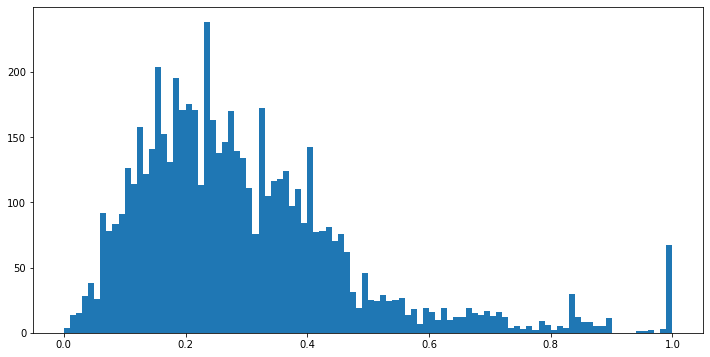

In [17]:
minmaxscaled_feature = minmaxscaler.fit_transform(pd.DataFrame(feature))
_ = plt.hist(minmaxscaled_feature, bins=100)
plt.show()

In [18]:
stats.normaltest(minmaxscaled_feature)

NormaltestResult(statistic=array([1603.65317768]), pvalue=array([0.]))

As such, if you need your variable to have more of a normal distribution, it's going to take more than min-max scaling.

## Common feature transformations for numeric data

### Log Transformation
One major use of logs is to create linearity from exponential relationships. This can help algorithms (e.g., linear models) capture the fit of many variables. Remember that logs take only strictly positive variables. If you have any negative values, you will have to rescale your data, remove them or find another way to deal with them.

$ x^{(t)} = g(x) = log(x) $



### Box Cox Transformation
If your variable has a skewed tail, this can be problematic for the assumption on normality. You can try to correct this with a Box Cox transformation. This only works with strictly positive values (greater than 0). You can always rescale variables so they meet this criteria before putting them into this formula.

$
    x^{(t)} = g(x; \lambda) =
    \begin{cases}
      \frac{x^\lambda - 1}{\lambda}, & \text{if}\ \lambda \neq 0 \\
      log(x), & \text{otherwise}
    \end{cases}
$




## Testing transformations
Let's look at a version of these which we have created from scratch and check what they do to our variable using histograms and box plots.

In [19]:
def box_cox_transform(var, power=0):

    try:
        assert (var > 0).all()  # Function only defined > 0
    except AssertionError:
        raise ValueError("Variable values must be strictly positive")

    # Special case lambda=0
    if power == 0:
        var = np.log(var)

    else:
        var = (var ** power - 1) / power

    return var

Now let's check the histogram of the regular feature of interest and its modified versions. Pay attention to the scale. What happens as the power of the BC and YJ transformation increases? What happens to the shape of the histogram?

In [20]:
# Adjust coefficient of Box Cox transformation on the feature to show plot below

bc1 = box_cox_transform(feature+1, power=0)  # Adding 1 as all features start at 0, not allowed in BC
bc2 = box_cox_transform(feature+1, power=.5)
bc3 = box_cox_transform(feature+1, power=1)

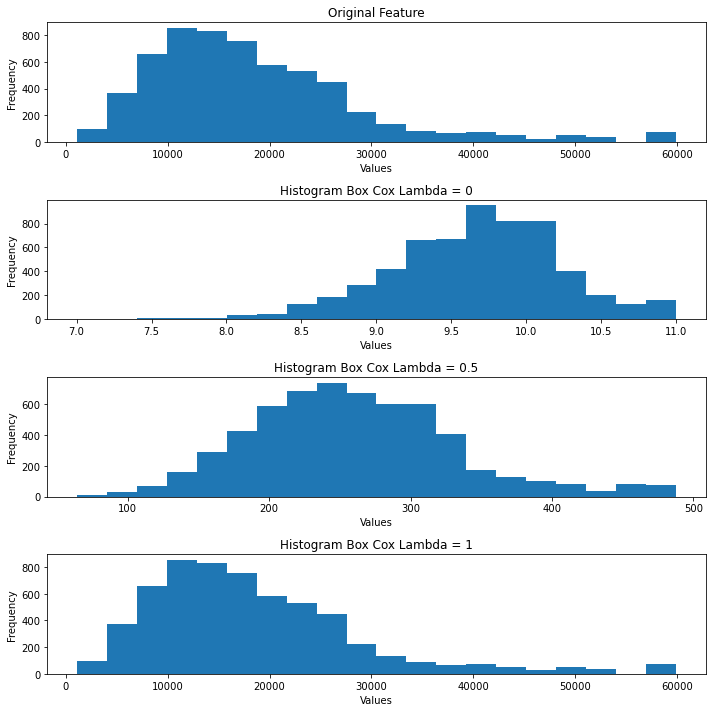

In [21]:
# Plot a histogram per coefficient of BC transformation

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(10)

ax1.hist(feature, bins=20)
ax2.hist(bc1, bins=20)
ax3.hist(bc2, bins=20)
ax4.hist(bc3, bins=20)

ax1.set_title('Original Feature')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Values')

ax2.set_title('Histogram Box Cox Lambda = 0')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Values')


ax3.set_title('Histogram Box Cox Lambda = 0.5')
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Values')


ax4.set_title('Histogram Box Cox Lambda = 1')
ax4.set_xlabel('Values')
ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Did you notice that the peak of the data moves? We are looking for a sweet spot where the peak is somewhere directly between the two tails so the distribution is almost perfectly bell-shaped. Note that the scale also changes pretty dramatically too. Make sure that you scale this variable after if necessary to make sure it fits your model requirements!

### Using `scipy` functions
Let's use the scipy version of the function and  see where it finds the true maximum point of normality. We can use the `scipy`  `stats` sublibrary to fit the feature and find the optimal lambda. Let's first start with Box Cox.

In [22]:
bc_fitted_feature, bc_fitted_lambda = stats.boxcox(feature+1) # Again, we are adding 1 because all features have 0s (not allowed in BC)

bc_fitted_lambda

0.19107151032822628

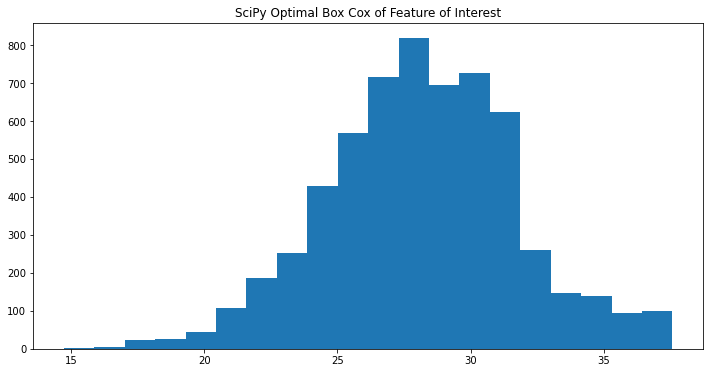

In [23]:
plt.hist(bc_fitted_feature, bins=20)
plt.title('SciPy Optimal Box Cox of Feature of Interest')
plt.show()

Lastly, let's do the normal test one last time with the optimal lambda found by `scipy`. We can see that the test statistic does not exceed the desired 0.05 but is much better than what we were dealing with previously.

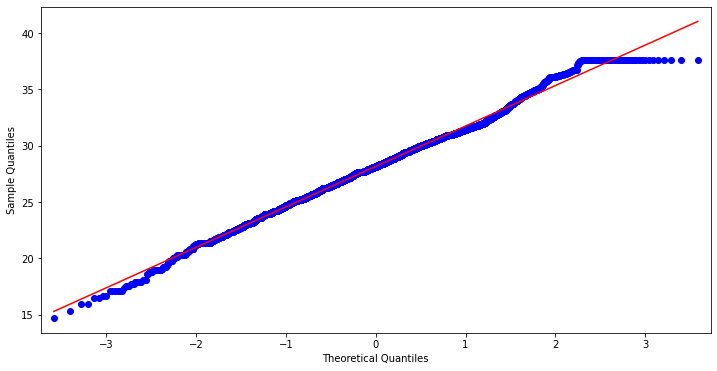

In [24]:
qqplot(bc_fitted_feature, line='s')
plt.show()

## Beware of in-sample biases when transforming features!
So, before we continue let's quickly just apply a simple transform to all of our variables. We will just standardize them for now. Remember that you should be doing any transformations separately to your train data and test data. You want to try to keep your test data as pure as possible. If you make transformations before, you risk not having a truly representative sample of new unseen data to test your model on. To see this, recall that scaling involves computing statistics like the mean, standard deviatio or min/max. It makes a difference whether you compute these statistics only from the training data or from the combination of the training and test date. Thus, first scaline the data and then splitting it into training and test is a bad idea. The scaler classes in `sklearn` are designed in a way to help you avoid this flaw. 

In [25]:
numeric_cols = ["LOAN", "MORTDUE", "VALUE", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO", "DEBTINC"]

standard = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = standard.fit_transform(X_train_scaled[numeric_cols])

X_test_scaled[numeric_cols] = standard.transform(X_test_scaled[numeric_cols])

X_test_scaled.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DELINQcat,DEROGzero
2187,-0.453621,0.581408,0.250458,DebtCon,Other,0.301268,-0.278435,-0.376379,0.363121,1.190222,-0.633454,0.572997,0,True
3005,-0.188259,0.368520,0.318881,IsMissing,Other,-0.243599,-0.278435,-0.376379,-0.075914,-0.103958,-0.129717,0.251079,0,True
4372,0.408807,0.934153,0.789106,HomeImp,ProfExe,0.301268,-0.278435,-0.376379,0.139596,-0.751048,0.172526,0.019905,0,True
28,-1.505594,-1.202978,-1.279406,HomeImp,Other,0.165051,0.940645,1.466099,1.198230,-0.751048,-1.237939,0.132262,1,False
2281,-0.425190,-0.180117,-1.188595,HomeImp,Other,-1.197115,-0.278435,-0.376379,1.456018,-0.103958,-1.338687,-1.218859,0,True


In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4768 entries, 3120 to 3294
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LOAN       4768 non-null   float64
 1   MORTDUE    4768 non-null   float64
 2   VALUE      4768 non-null   float64
 3   REASON     4768 non-null   object 
 4   JOB        4768 non-null   object 
 5   YOJ        4768 non-null   float64
 6   DEROG      4768 non-null   float64
 7   DELINQ     4768 non-null   float64
 8   CLAGE      4768 non-null   float64
 9   NINQ       4768 non-null   float64
 10  CLNO       4768 non-null   float64
 11  DEBTINC    4768 non-null   float64
 12  DELINQcat  4768 non-null   int64  
 13  DEROGzero  4768 non-null   bool   
dtypes: bool(1), float64(10), int64(1), object(2)
memory usage: 526.2+ KB


In [27]:
# further prelims
train_df = pd.concat([X_train_scaled, y_train], axis=1, join="inner")
train_len = len(X_train)

# full data
X_full = pd.concat(objs=[X_train_scaled, X_test_scaled], axis=0)



## On One-Hot Encoding 

The differences between sklearn.preprocessing.OneHotEncoder and pandas.get_dummies:

In short, if I’m doing machine learning then I should use OneHotEncoder(ohe) over get_dummies. OHE does the same things as get dummies but in addition, OHE saves the exploded categories into it’s object.

Saving exploded categories is extremely useful when I want to apply the same data pre-processing on my test set. If the total number of unique values in a categorical column is not the same for my train set vs test set, I’m going to have problems.

In our case however, we are fine with the pandas.get_dummies approach.

See the examples at https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html for the
OneHotEncoder in sklearn.

In [ ]:
# often called "dummy" variables
# pandas get dummies
X_full = pd.get_dummies(X_full, columns = ['REASON', 'JOB'], drop_first=True)

# one-hot encoded versions
X_train_dummies = X_full[:train_len]
X_test_dummies = X_full[train_len:]

X_train_dummies.head()

# add constants for the linear models later:
import statsmodels.api as sm 

X_train_dummies = sm.add_constant(X_train_dummies)
X_test_dummies = sm.add_constant(X_test_dummies)

# Feature Selection

## Filter methods
Filters are statistical methods which test variables one by one and their relevance to the task at hand. Since they are relatively easy to compute, they tend to be checked first. The next methods of feature selection require more computational power, therefore eliminating variables using filters first will save time later.

Let's recall the chart we saw in class. The columns represent the target, is it continuous or discrete? The rows represent the variable to test, is it continuous or discrete/categorical? The best test is the one that corresponds to the right row/column.

```
Data Types      | CONTINUOUS TARGET     | DISCRETE TARGET
-------------------------------------------------------------------------------
CONTINUOUS VAR  | Pearson Correlation   | Fisher Score
CATEGORICAL VAR | Fisher Score / ANOVA  | Chi-Square / Information Gain
```



### Pearson Correlation
This is probably the most common correlation metric used. It is remarkable for its very simple implementation (covariance divided by the root of the product of each variance):

$$ \rho = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2 \sum_{i=1}^{n} (y_i - \overline{y})^2}} $$

This correlation is best used when target and the (independent) variable to check are **both continuous**. The coefficient produced is bound between -1 and 1. It is recommended to only keep variables with a high correlation, however there is no rule that you can always follow. The closer that this coefficient is to 0, the less correlation between the variable and the target.



### Fisher Score
This method of finding correlation can be used if **either** the target or variable in question is binary. It generalizes into an ANOVA test if there are multiple categories.

$$ FS = \frac{|\bar{x}_G - \bar{x}_B |}{\sqrt{s^2_G + s^2_B}} $$

### Analysis of Variance (ANOVA)
ANOVA specifically compares the means of a **feature with more than 2 categories with a continuous target**. For example, we had the feature `JOB`. If our target was continuous, ANOVA would be testing if each category in `JOB` actually corresponded to a different mean in our target. 

So, we first find the sum of squares between categories:
$$ SSD_B = \sum_{i=1}^k \sum_{j=1}^n \left(\bar{x}_i - \bar{x}_.\right)^2 = n\sum_{i=1}^k \left(\bar{x}_i - \bar{x}_.\right)^2 $$

We then find the sum of square difference within categories:
$$ SSD_W = \sum_{i=1}^k\sum_{j=1}^n \left(x_{ij} - \bar{x}_i \right)^2 $$

Now we divide the $ SSD_B $ by its degree of freedom: k categories minus 1. This gives us the mean $ SSD_B $. And then we divide $ SSD_W $ by its degrees of freedom, number of observations minus k categories. This gives us the mean $ SSD_W $.

$$ \mu_B = \frac{SSD_B}{k-1} $$

$$ \mu_W = \frac{SSD_W}{n-k} $$

Now we have the F-stastic that we can use.
$$ F = \frac{\mu_B}{\mu_W} $$

We must compare this value to the [F-Distribution Table](http://www.socr.ucla.edu/Applets.dir/F_Table.html) and decide whether we want to include it in the analysis.



### Chi-Square Analysis

Chi Square tests check whether events are dependent on one another. If there is no dependence between the target and the feature, it becomes less likely that it would actually would be meaninigful to include in the analysis.

$$ \chi^2 = \sum{\frac{(O_i - E_i)^2}{E_i}} $$

Chi square is only used when **both the feature of interest and the target are both categorical variables**. You must use a [chi-square table](https://web.ma.utexas.edu/users/davis/375/popecol/tables/chisq.html) (this one is alpha = 0.10) to assess whether you would like to include this varible in the end or not. Remember that if one category has too little observations, this test's results may not be accurate.




### Information Gain / Entropy

Entropy normally means chaos. In machine learning, it is defined as an equal chance of selecting any category of the target variable. If you have a set of observations and there is an equal mix of all target labels in this set, entropy is maximized. If you can find some feature split to cause only one target label in each section of data, then entropy is minimized. Information Gain is the difference between the entropy before and the sum of entropy in each group after a split. As such, this method is most appropriate for **both a discrete feature and discrete target**.

Entropy is calculated by the following formula:

$$ E = -\sum^C_i p_i \cdot log_2(p_i) $$

Then information gain can be defined as the sum of entropy in total minus entropy of each category separately (this is the same as entropy in a decision tree):

$$ \text{Info Gain} = E_\text{total} - \sum{E_\text{category}}  $$

It is up to you to decide how little information gain to tolerate to consider a variable to be helpful.

Now that we know some of these methods, let's see what they look like in some code from scratch. Note that the function below is not made to deal with every type of data (especially if the target is a variable with multiple categories). However, we can see quite a lot of the decisions that you will need to make behind the scenes for it to all work.

In [28]:
class filter_binary_target:
    def __init__(self, df, target):
        self.target = target
        self.data_head = df.head()

    def auto_filter_binary_target(self):
        print('Data must be in a clean pandas DataFrame. Categorical variables must be of data type bool or category. Continuous variables must be int64 or float64.')
        data_no_target = df.drop(columns=self.target)
        columns = ['Data Type', 'Metric', 'Score']
        index = data_no_target.columns
        result = pd.DataFrame(index=index, columns=columns)

        for col in data_no_target:
            if data_no_target.dtypes[col] == 'bool' or data_no_target.dtypes[col].name == 'category':
                result.loc[col, 'Data Type'] = "discrete"
                result.loc[col, 'Metric'] = "Chi2"
                result.loc[col, 'Score'] = self.IV_binary_target(feature=col)

            if data_no_target.dtypes[col] == 'int64' or data_no_target.dtypes[col] == 'float64':
                result.loc[col, 'Data Type'] = "continuous"
                result.loc[col, 'Metric'] = "Fisher"
                result.loc[col, 'Score'] = self.fisher_binary_target(feature=col)

        return result

    def IV_binary_target(self, feature): 
        data = pd.DataFrame()
    
        data['Count'] = df[feature].value_counts()
        data['Bad'] = df.groupby([feature])[self.target].sum()
        data['Good'] = data['Count'] - data['Bad']
    
        data["Distribution Bad"] = data["Bad"] / data["Bad"].sum()
        data["Distribution Good"] = data["Good"] / data["Good"].sum()
    
        data['WOE'] = np.log(data["Distribution Good"] / data["Distribution Bad"])
        data.replace({"WOE": {np.inf: 0, -np.inf: 0}})

        data["IV"] = data["WOE"] * (data["Distribution Good"] - data["Distribution Bad"])

        iv = data["IV"].sum()

        return iv

    def fisher_binary_target(self, feature):
        mu_0 = df.groupby(df[self.target])[feature].mean()[0]
        mu_1 = df.groupby(df[self.target])[feature].mean()[1]
        var_0 = df.groupby(df[self.target])[feature].var()[0]
        var_1 = df.groupby(df[self.target])[feature].var()[1]

        num = abs(mu_0 - mu_1)
        den = (var_0 + var_1) ** 0.5
        score = num/den
    
        return score

    def pearson(self, feature):  # since our target is binary, we actually don't need this. However, if you would like to expand this class, you can use this code
        mean_feature = df[feature].mean()
        mean_target = df[self.target].mean()
        num = ((df[feature] - mean_feature)*(df[self.target] - mean_target)).sum()
        den = (((df[feature] - mean_feature)**2).sum() * ((df[self.target] - mean_target)**2).sum()) ** .5
        rho = num/den
        return rho

In [29]:
# Use the functionality of our WoE class for encoding the feature JOB
train_df = pd.concat([X_train_scaled, y_train], axis=1, join="inner")
filter = filter_binary_target(df=train_df, target="BAD")
filter.auto_filter_binary_target()

Data must be in a clean pandas DataFrame. Categorical variables must be of data type bool or category. Continuous variables must be int64 or float64.


,Data Type,Metric,Score
LOAN,continuous,Fisher,0.13309
MORTDUE,continuous,Fisher,0.0951093
VALUE,continuous,Fisher,0.106516
REASON,discrete,Chi2,0.00861846
JOB,discrete,Chi2,0.0778732
YOJ,continuous,Fisher,0.0979491
DEROG,continuous,Fisher,0.358356
DELINQ,continuous,Fisher,0.473846
CLAGE,continuous,Fisher,0.324169
NINQ,continuous,Fisher,0.275753


So let's analyze this output. We cannot directly compare Chi2 and Fisher scores but we can judge them relative to other variables calculated with the same score. We can see that of our 3 variables tested with Chi2, `REASON` is particularly weak and does not pass a 0.025 value threshold for Chi2. Therefore, we should eliminate it from the analysis. We can also see that of the variables for which we calculated a Fisher score, `CLNO`, `MORTDUE` and `YOJ` are all quite low.

At this point we could choose to eliminate these variables. However, let's leave them in for a little check using wrapper methods. 

## Wrappers
Unlike filter methods, which check one variable at a time with a statistical framework, wrappers try to iteratively build models in different ways to detect variables thatimpact a model's performance the most. As you can imagine, there are two major ways of doing this.
1. You add variables one at a time
2. You remove variables one at a time

Each time, you are double checking how the model performs with the inclusion or exclusion of a certain variable.

In [30]:
# Let's first set the one-hot encoded version of the dataframe as the default
X_train = X_train_dummies
X_test = X_test_dummies

In [31]:
from sklearn.linear_model import LogisticRegression # We will use sklearn here as it is required in the next algorithms
from sklearn.metrics import roc_auc_score

clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train,  np.ravel(y_train.values))
y_pred = clf.predict(X_test)
roc_auc_score(y_test, y_pred) # Note this value is different from the statsmodels value we found before for the same model earlier

0.6357561742196783

### Stepwise regression (forward regression)
We will start with the first wrapper method described above. We can easily create this with a for-loop, but we will spare you the complexities by using `mlxtend` to sequentially add our possible features to the model using the function `SequentialFeatureSelector`. The machine will add variables one at a time and double check the model's performance. Note that a `sklearn` model is required as input to this function.

Note that unfortunately `sklearn` does not yet support stepwise regression on its own. However, if you'd like, there are ways to code it yourself through a loop that tries to find the best combination of variables through iterative model building like the [second answer to this StackExchange question](https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm).

Let's use the algorithm from `mlextend` and check whether it corresponds to the features that our filter model also chose. In case you run this code on your own machine, you might have to [install the `mlextend` package first](https://anaconda.org/conda-forge/mlxtend).



In [32]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

clf = LogisticRegression(random_state=888, max_iter=1000, tol=0.01)
sfs = SFS(clf, 
           k_features=(3,12), 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=3)

sfs = sfs.fit(X_train, np.ravel(y_train.values))

In [33]:
print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_names_))

best combination (ACC: 0.843): ('VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'DEBTINC', 'REASON_HomeImp', 'REASON_IsMissing', 'JOB_Office', 'JOB_Self')



We can see from this regression, some of the variables that were candidates for elimination according to our filter method were actually kept. This may be because there are some variable interaction which we cannot observe using filter methods. It would be up to the analyst to try all combinations and determine the one that works best for the data.

We can plot the percent correctly classified vs. the number of selected features to see the algorithm's findings.

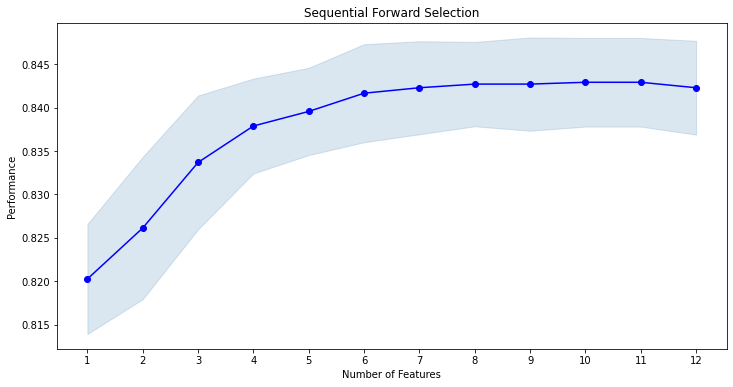

In [34]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

plot_sfs(sfs.get_metric_dict())
plt.title('Sequential Forward Selection')

plt.show()

Lastly, let's check the AUC of the test set to see how this selection of features did on unseen data.



In [35]:
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

clf.fit(X_train_sfs, np.ravel(y_train.values))
y_pred = clf.predict(X_test_sfs)

In [36]:
roc_auc_score(y_test, y_pred)

0.6297320778341362

### Recursive feature elimination (backward selection)

Another extremely useful variable selection method is backward selection. We can actually implement it very easily using the `RFECV` function from `sklearn`. You can view the documentation for this function [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV). Let's see if it selects similar variables as our last wrapper model and the filter model.

In [37]:
from sklearn.feature_selection import RFECV
clf = LogisticRegression(random_state=888, max_iter=10000, tol=0.001)

rfecv = RFECV(estimator=clf, step=1, cv=2, scoring='accuracy')
X_train_new = rfecv.fit(X_train,  np.ravel(y_train.values))

print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 15


In [38]:
X_train.columns[rfecv.support_]

Index(['LOAN', 'MORTDUE', 'VALUE', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'DEBTINC', 'DELINQcat', 'DEROGzero', 'REASON_HomeImp',
       'REASON_IsMissing', 'JOB_Office', 'JOB_Sales', 'JOB_Self'],
      dtype='object')

In this regression, different variables were dropped and again they don't correspond to the candidates we found through our filter process. Again, this may be caused by some variable interaction, which we cannot observe by using filter methods. It is up to your discretion to experiment with combinations and determine the best course of action to solve your problem.

We can plot the percent correctly classified vs. the number of selected features to see the algorithm's findings.

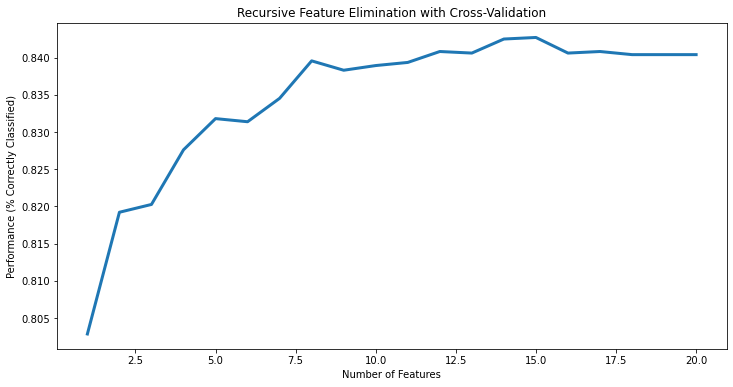

In [39]:
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of Features')
plt.ylabel('Performance (% Correctly Classified)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3)

plt.show()

Lastly, let's check the mean error on the test set to see how this selection of features did on unseen data.

In [40]:
y_pred = rfecv.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6345828701870047

## Appendix: Pipelines

After we have decided how we would like our finalized data to look like in the end, we will likely have to repeat the modifications to our data set several times over (for the train set, test set, new batches of data etc...). In this case, it can be very useful to set up a pipeline which makes the same adjustments to raw data.

In [41]:
# Let's reload the raw data

data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_prepared.csv' 
df = pd.read_csv(data_url)

# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [43]:
# Now let's use a pipeline to transform our data using some of what we have learned above

from sklearn.pipeline import Pipeline
#from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# If you only want a transformation on select columns, it is good to first use ColumnTransformer
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [3, 4]), # ('step_name', fun(), list_cols) always follow this format for each step of the transfomer
                                              ('scl', StandardScaler(), [0, 1, 2, 5, 6, 7, 8, 9, 10])], # Note that below RF is used as a classifier, thus, scaling is not exactly necessary
                                              remainder='passthrough')

# Construct some pipelines
pipe = Pipeline([
                ('t', transformer), # ('step_name', transfomer) always follow this format for transformers in the pipeline
                ('clf', RandomForestClassifier()) # ('step_name', fun()) add parantheses for other functions
                ])

This little bit of code wraps-up almost all of the preprocessing steps, which we discussed in this notebook. The code does look a little complicated but you will agree that it is concise. So the idea is that we chain operations together, such that the result of one operation (e.g., one-hot-coding of variables) are forwarded as input to a subsequent step. Above, we effectively code two chains, one chain of feature transformations and later one chain with two steps, all feature transformations together and learning a classifier. It is very easy to execute the chain of operations, i.e. the pipeline:

In [44]:
# Learning a RF classifier on the preprocessed data set with one line:
pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('t',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  [3, 4]),
                                                 ('scl', StandardScaler(),
                                                  [0, 1, 2, 5, 6, 7, 8, 9,
                                                   10])])),
                ('clf', RandomForestClassifier())])

In [45]:
# Let's next get predictions and compute AUC of the learned RF classifier
y_pred = pipe.predict(X_test)
roc_auc_score(y_test, y_pred) # check AUC

0.8319019930826377

The example highlights that once the pipeline is set up, something that you could do in a custom function, which you the put into a .py file, you can run it with basically one line of code. These tools help you to focus your notebook to the most important aspects of your task. For example, the next tutorial will look into [model diagnosis and interpretation](https://github.com/Humboldt-WI/bads/blob/master/tutorials/10_nb_interpretale_ML.ipynb). You can grasp that we will first need a model before talking about interpreting that model. Using the command `pipe.fit(X_Train, y_train)` you can get such a model super easily, and focus your notebook on model interpretation. More generally, piplines help you to keep your code clean and comprehensible, and are, therefore, a useful thing to have on your list.